# Handling Raster data in Python

## Automatized data download


For this lesson, we need to download data from couple of different places. For this purpose I will show
how to download data automatically using Python programming which might be quite useful thing to know.

The data files that we are using in this tutorial will be obtained from [PaITuli spatial data service ](https://avaa.tdata.fi/web/paituli/latauspalvelu).
We will be using Landsat 8 image from Helsinki area produced by NASA, USGS & Latuviitta which I have already clipped to reduce the size of the file (raster files are often fairly large in size),
and a 2mx2m Digital Elevation Model (DEM) produced by National Land Survey of Finland.

You can download those files into your computer automatically with following script in which we will be using [urllib module](https://docs.python.org/3/library/urllib.html) to download the data with Python:



In [3]:
import os
import urllib

def get_filename(url):
    """
    Parses filename from given url
    """
    if url.find('/'):
        return url.rsplit('/', 1)[1]

# Filepaths
outdir = r"data"

# File locations
url_list = ["https://github.com/Automating-GIS-processes/CSC18/raw/master/data/Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif"]

# Create folder if it does no exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Download files
for url in url_list:
    # Parse filename
    fname = get_filename(url)
    outfp = os.path.join(outdir, fname)
    # Download the file if it does not exist already
    if not os.path.exists(outfp):
        print("Downloading", fname)
        r = urllib.request.urlretrieve(url, outfp)

## Reading raster files with Rasterio

[Rasterio](https://mapbox.github.io/rasterio/) is a highly useful module for raster processing which you can use for reading and writing [several different raster formats](http://www.gdal.org/formats_list.html) in Python. Rasterio is based on [GDAL](http://www.gdal.org/) and Python automatically registers all known GDAL drivers for reading supported
formats when importing the module. Most common file formats include for example [TIFF and GeoTIFF](http://www.gdal.org/frmt_gtiff.html),
[ASCII Grid](http://www.gdal.org/frmt_various.html#AAIGrid) and [Erdas Imagine .img](http://www.gdal.org/frmt_hfa.html) -files.

[Landsat 8](http://landsat.gsfc.nasa.gov/landsat-8/landsat-8-bands) bands are stored as separate GeoTIFF -files in the original package. Each band contains information of surface reflectance from different ranges of the electromagnetic spectrum.

### Download data

**Download the data** package from [here](http://www.helsinki.fi/science/accessibility/opetus/autogis/L5_data.zip). The package contains various TIF-files that will be explored during the tutorials. 

Let's start with inspecting one of the files we downloaded:


In [16]:
# import needed libraries
import rasterio
import os
import numpy as np
%matplotlib inline

# Data dir
data_dir = "L5_data"
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")

# Open the file:
raster = rasterio.open(fp)

# Check type of the variable 'raster'
type(raster)

rasterio.io.DatasetReader

Okey so from here we can see that our `raster` variable is a `rasterio._io.RasterReader` type which means that we have opened the file for reading.

## Read raster file properties

Let's have a closer look at the properties of the file:

In [5]:
# Projection
raster.crs

CRS({'proj': 'tmerc', 'lat_0': 0, 'lon_0': -183, 'k': 0.9996, 'x_0': 500000, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True})

In [6]:
# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
raster.transform


Affine(28.5, 0.0, 698592.0,
       0.0, -28.5, 6697870.5)

In [7]:
# Dimensions
print(raster.width)
print(raster.height)



1288
1439


In [8]:
# Number of bands
raster.count


7

In [9]:
# Bounds of the file
raster.bounds

BoundingBox(left=698592.0, bottom=6656859.0, right=735300.0, top=6697870.5)

In [10]:
# Driver (data format)
raster.driver

'GTiff'

In [11]:
# No data values for all channels
raster.nodatavals

(None, None, None, None, None, None, None)

In [12]:
# All Metadata for the whole raster dataset
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1288,
 'height': 1439,
 'count': 7,
 'crs': CRS({'proj': 'tmerc', 'lat_0': 0, 'lon_0': -183, 'k': 0.9996, 'x_0': 500000, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}),
 'transform': Affine(28.5, 0.0, 698592.0,
        0.0, -28.5, 6697870.5)}

## Get raster bands

Different bands of a satellite images are often stacked together in one raster dataset. In our case, all seven bands of the Landsat 8 scene are included in our GeoTIFF and the `count` is hence 7.

In order to have a closer look at the values stored in the band, we will take advantage of the [GDAL Band API](http://gdal.org/python/osgeo.gdal.Band-class.html).


In [14]:
# Read the raster band as separate variable
band1 = raster.read(1)

# Check type of the variable 'band'
print(type(band1))

# Data type of the values
print(band1.dtype)

<class 'numpy.ndarray'>
uint8


Now we have the values of the raster band stored in the variable `band1`.

Data type of the band can be interpreted with the help of GDAL documentation on [Pixel data types](http://www.gdal.org/gdal_8h.html#a22e22ce0a55036a96f652765793fb7a4). Unsigned integer is always equal or greater than zero and signed integer can store also negative values. For example, an unsigned 16-bit integer can store 2^16 (=65,536) values ranging from 0 to 65,535.


## Band statistics

Next, let's have a look at the values that are stored in the band. As the values of the bands are stored as numpy arrays, it is extremely easy to calculate basic statistics by using basic numpy functions.

In [18]:
# Read all bands
array = raster.read()

# Calculate statistics for each band
stats = []
for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
stats

[{'min': 0, 'mean': 59.63132232528628, 'median': 61.0, 'max': 255},
 {'min': 0, 'mean': 43.13342814842951, 'median': 43.0, 'max': 255},
 {'min': 0, 'mean': 36.29418775547201, 'median': 31.0, 'max': 255},
 {'min': 0, 'mean': 35.0946303937776, 'median': 13.0, 'max': 255},
 {'min': 0, 'mean': 37.63263502518571, 'median': 13.0, 'max': 255},
 {'min': 0, 'mean': 105.8221477777442, 'median': 114.0, 'max': 175},
 {'min': 0, 'mean': 26.28348760569581, 'median': 14.0, 'max': 255}]

# Visualizing raster layers

Of course, it is always highly useful to take a look how the data looks like. This is easy with the `plot.show()` -function that comes with rasterio. This can be used to plot a single channel of the data or using mutiple channels simultaniously (multiband). The [channels for the data used in here](https://etsin.avointiede.fi/storage/f/paituli/latuviitta/Landsat_kanavat.pdf) and their corresponding wavelengths are:

 1. Blue (0.45 - 0.515)
 2. Green (0.525 - 0.605)
 3. Red (0.63 - 0.69)
 4. NIR (0.75 - 0.90)
 5. IR (1.55 - 1.75)
 

## Basic plotting


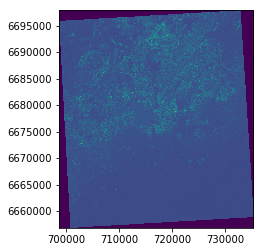

In [43]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
%matplotlib inline

# Data dir
data_dir = "L5_data"

# Filepath
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")

# Open the file:
raster = rasterio.open(fp)

# Plot band 1
show((raster, 1))

Here we can see that the `show` function created a map showing the pixel values of band 1.

Let's see how the different bands look like by placing them next to each other:

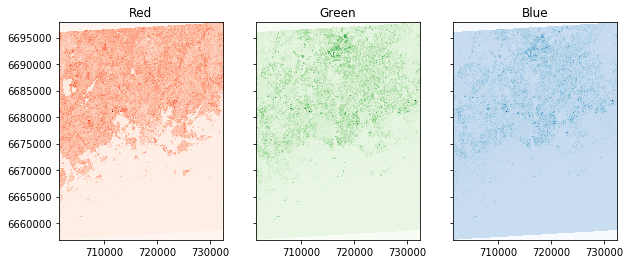

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((raster, 4), cmap='Reds', ax=ax1)
show((raster, 3), cmap='Greens', ax=ax2)
show((raster, 1), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")


## RGB True color composite

Next let's see how we can plot these channels as a normal RGB image.

- First we need to read the bands into numpy arrays and normalize the cell values into scale ranging from 0.0 to 1.0:

In [41]:
# Read the grid values into numpy arrays
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized band stats:
0.0 - 1.0 mean: 0.1423301480606746
0.0 - 1.0 mean: 0.16915069862129217
0.0 - 1.0 mean: 0.23384832284425988


As the statistics show, now the arrays have been normalized into scale from 0 to 1. 

- Next we need to stack the values from different values together to produce the RGB true color composite. For this we can use Numpy's [dstack()](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.dstack.html) -function:

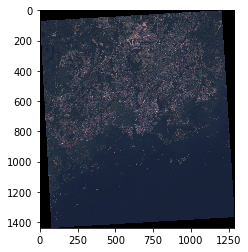

In [51]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

Here we go, now we have a typical RGB natural color composite image that looks like a photograph taken with the satellite. 

## False color composite

Following the previous example, it is easy to create false color composites with different band configurations. 

- One of the typical one, is to replace the blue band with near infra-red that can be used to detect vegetation easily where red color is emphasized. Let's use the same raster file as input, and generate our first false color composite:

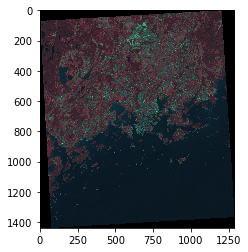

In [52]:
# Read the grid values into numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Normalize the values using the function that we defined earlier
nirn = normalize(nir)
redn = normalize(red)
greenn = normalize(green)

# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

# Let's see how our color composite looks like
plt.imshow(nrg)

As we can see, now the vegetation can be seen more easily from the image (red color).

## Histogram of the raster data

Typically when working with raster data, you want to look at the histogram of different bands in your data. Luckily that is really easy to do with rasterio by using the `plot.show_hist()` function.


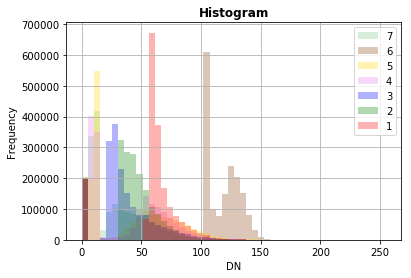

In [32]:
from rasterio.plot import show_hist
    
show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram")

Now we can easily see how the wavelengths of different bands are distributed.

# Masking / clipping raster

One common task in raster processing is to clip raster files based on a Polygon. The following example shows how to clip a large raster based on a bounding box around Helsinki Region.


- Import modules and specify the input and output filepaths

In [21]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import os
%matplotlib inline

# Data dir
data_dir = "L5_data"

# Input raster 
fp = os.path.join(data_dir, "p188r018_7t20020529_z34__LV-FIN.tif")

# Output raster
out_tif = os.path.join(data_dir, "Helsinki_Masked.tif")

- Let's start by opening the raster in read mode and visualizing it (using specific colormap called `terrain`):

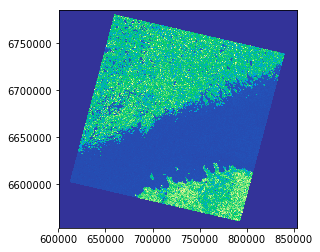

In [7]:
# Read the data
data = rasterio.open(fp)

# Visualize the NIR band
show((data, 4), cmap='terrain')

Okey, as you can see, we have a huge raster file where we can see the coastlines of Finland and Estonia. What we want to do next is to create a bounding box around Helsinki region and clip the raster based on that.

- Next, we need to create a bounding box for our area of interest with Shapely.

In [8]:
# WGS84 coordinates
minx, miny = 24.60, 60.00
maxx, maxy = 25.22, 60.35
bbox = box(minx, miny, maxx, maxy)

- Create a GeoDataFrame from the bounding box

In [9]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
print(geo)

                                            geometry
0  POLYGON ((25.22 60, 25.22 60.35, 24.6 60.35, 2...


As we can see now we have a GeoDataFrame with Polygon inside. To be able to clip the raster with this Polygon, it is required that the data has identical coordinate reference system.

-  Re-project into the same coordinate system as the raster data. We can access the crs of the raster using attribute `.crs.data`:

In [11]:
# Project the Polygon into same CRS as the grid 
geo = geo.to_crs(crs=data.crs.data)

# Print crs
geo.crs

{'init': 'epsg:32634'}

- Next we need to get the coordinates of the geometry in such a format that rasterio wants them. This can be conducted easily with following function:

In [12]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

- Get the geometry coordinates by using the function.

In [13]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[735275.3533476053, 6658919.843253607], [732783.55612074, 6697846.086795722], [698608.1329965619, 6695816.080575278], [700733.5832412266, 6656875.248540204], [735275.3533476053, 6658919.843253607]]]}]


Okay, as we can see rasterio wants to have the coordinates of the Polygon in `GeoJSON` format.

- Now we are ready to clip the raster with the polygon using the `coords` variable that we just created. Clipping the raster can be done easily with the `mask` function that we imported in the beginning from `rasterio`, and specifying ``clip=True``.


In [16]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

- Next, we need to modify the metadata. Let's start by copying the metadata from the original data file.

In [17]:
# Copy the metadata
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8877, 'height': 8106, 'count': 7, 'crs': CRS({'init': 'epsg:32634'}), 'transform': Affine(28.5, 0.0, 600466.5,
       0.0, -28.5, 6784966.5)}


- Next we need to parse the EPSG value from the CRS so that we can create a `Proj4` -string using `PyCRS` library (to ensure that the projection information is saved correctly).

In [18]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

32634


- Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text):

In [19]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4()}
                         )

- Finally, we can save the clipped raster to disk with following command:

In [22]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

- Let's still check that the result is correct by plotting our new clipped raster.

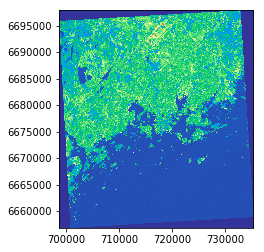

In [23]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

# Visualize
show((clipped, 5), cmap='terrain')

Great, it worked! This is how you can easily clip (*mask*) raster files with rasterio.

# Raster map algebra

Conducting calculations between bands or raster is another common GIS task. Here, we will be calculating `NDVI` (Normalized difference vegetation index) based on the Landsat dataset that we have downloaded from Helsinki region. Conducting calculations with rasterio is fairly straightforward if the extent etc. matches because the values of the rasters are stored as `numpy` arrays (similar to the columns stored in Geo/Pandas, i.e. `Series`).

## Calculating NDVI 

In this tutorial, we will see how to calculate the NDVI (Normalized difference vegetation index) based on two bands: band-4 which is the Red channel and band-5 which is the Near Infrared (NIR).

- Let's start by importing the necessary modules `rasterio` and `numpy` and reading the raster file that we masked for Helsinki Region:


In [1]:
import rasterio
import numpy as np
from rasterio.plot import show
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Data dir
data_dir = "data"

# Filepath
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")

# Open the raster file in read mode
raster = rasterio.open(fp)

- Let's read the red and NIR bands from our raster source ([ref](https://etsin.avointiede.fi/storage/f/paituli/latuviitta/Landsat_kanavat.pdf)):

36.29418775547201
35.0946303937776
<class 'numpy.ndarray'>


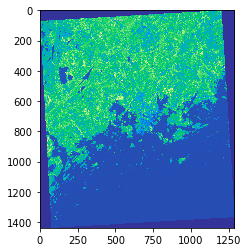

In [2]:
# Read red channel (channel number 3)
red = raster.read(3)
# Read NIR channel (channel number 4)
nir = raster.read(4)

# Calculate some stats to check the data
print(red.mean())
print(nir.mean())
print(type(nir))

# Visualize
show(nir, cmap='terrain')

As we can see the values are stored as `numpy.ndarray`. From the map we can see that NIR channel reflects stronly (light green) in areas outside the Helsinki urban areas.

- Let's change the data type from uint8 to float so that we can have floating point numbers stored in our arrays:

In [3]:
# Convert to floats
red = red.astype('f4')
nir = nir.astype('f4')
nir

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Now we can see that the numbers changed to decimal numbers (there is a dot after the zero).

Next we need to tweak the behaviour of numpy a little bit. By default numpy will complain about dividing with zero values. We need to change that behaviour because we have a lot of 0 values in our data.


In [4]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

- Now we are ready to calculate the NDVI. This can be done easily with simple map algebra and using the NDVI formula and passing our numpy arrays into it:

In [5]:
# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)

- Let's plot the results so we can see how the index worked out:

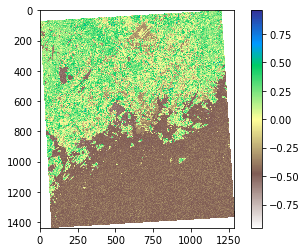

In [6]:
%matplotlib inline
# Plot the NDVI
plt.imshow(ndvi, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar()

As we can see from the map, now the really low NDVI indices are located in water and urban areas (middle of the map) whereas the areas colored with green have a lot of vegetation according our NDVI index. 

# Creating a raster mosaic

Quite often you need to merge multiple raster files together and create a `raster mosaic`. This can be done easily with the `merge()` -function in Rasterio.

Here, we will create a mosaic based on 2X2m resolution DEM files (altogether 12 files) covering the Helsinki Metropolitan region. If you have not downloaded the DEM files yet, you can do that by running the script from download-data -section of the tutorial.

As there are many `tif` files in our folder, it is not really pracical to start listing them manually. Luckily, we have a module and function called `glob` that can be used to create a list of those files that we are interested in based on search criteria.

Let's start by:
   
  - Importing required modules
  - Finding all `tif` files from the folder where the file starts with `L` -letter.


In [1]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
%matplotlib inline

# File and folder paths
dirpath = "L5_data"
out_fp = os.path.join(dirpath, "Helsinki_DEM2x2m_Mosaic.tif")

# Make a search criteria to select the DEM files
search_criteria = "L*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

L5_data\L*.tif


Now we can see that we have a search criteria (variable `q`) that we can pass to `glob` -function.

- List all digital elevation files with glob() -function:

In [2]:
# glob function can be used to list files from a directory with specific criteria
dem_fps = glob.glob(q)

# Files that were found:
dem_fps

['L5_data\\L4133A.tif',
 'L5_data\\L4133B.tif',
 'L5_data\\L4133C.tif',
 'L5_data\\L4133D.tif',
 'L5_data\\L4133E.tif',
 'L5_data\\L4133F.tif',
 'L5_data\\L4134A.tif',
 'L5_data\\L4134B.tif',
 'L5_data\\L4134C.tif',
 'L5_data\\L4134D.tif',
 'L5_data\\L4134E.tif',
 'L5_data\\L4134F.tif']

Great! Now we have all those 12 files in a list and we can start to make a mosaic out of them.

- Let's first create a list for the source raster datafiles (in read mode) with rasterio that will be used to create the mosaic:


In [3]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic


[<open DatasetReader name='L5_data\L4133A.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133B.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133C.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133D.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133E.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133F.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134A.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134B.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134C.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134D.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134E.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134F.tif' mode='r'>]

As we can see, now the list contains all those files as raster objects in read mode (´mode='r'´).

- Let's plot a few of them next to each other to see how they look like:

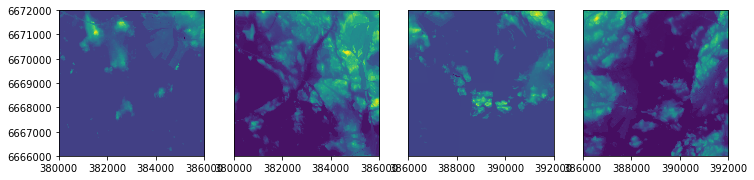

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(src_files_to_mosaic[0], ax=ax1)
show(src_files_to_mosaic[1], ax=ax2)
show(src_files_to_mosaic[2], ax=ax3)
show(src_files_to_mosaic[3], ax=ax4)

# Do not show y-ticks values in last three axis
for ax in [ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)
    

As we can see we have multiple separate raster files that are actually located next to each other. Hence, we want to put them together into a single raster file that can by done by creating a raster mosaic.

- Now as we have placed the individual raster files in read -mode into the `source_files_to_mosaic` -list, it is really easy to merge those together and create a mosaic with rasterio's `merge` function:

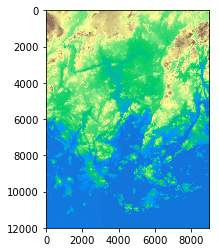

In [5]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# Plot the result
show(mosaic, cmap='terrain')

Great, it looks correct! Now we are ready to save our mosaic to disk.

- Let's first update the metadata with our new dimensions, transform and CRS:

In [6]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                 }
                )

- Finally we can write our mosaic to our computer:

In [7]:
# Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

That's it! Easy!

Zonal statistics
================

Quite often you have a situtation when you want to summarize raster datasets based on vector geometries, such as calculating the average elevation of specific area.

[Rasterstats](https://github.com/perrygeo/python-rasterstats) is a Python module that does exactly that, easily.

- Let's start by reading the data:

In [1]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import osmnx as ox
import geopandas as gpd
import os
import matplotlib.pyplot as plt
%matplotlib inline

# File path
data_dir = "L5_data"
dem_fp = os.path.join(data_dir, "Helsinki_DEM2x2m_Mosaic.tif")

# Read the Digital Elevation Model for Helsinki
dem = rasterio.open(dem_fp)
dem

<open DatasetReader name='L5_data\Helsinki_DEM2x2m_Mosaic.tif' mode='r'>

Good, now our elevation data is in read mode.

Next, we want to calculate the elevation of two neighborhoods located in Helsinki, called `Kallio` and `Pihlajamäki`, and find out which one of them is higher based on the elevation data. We will use a package called [OSMnx](https://github.com/gboeing/osmnx) to fetch the data from OpenStreetMap for those areas.

- Specify place names for `Kallio` and `Pihlajamäki` that Nominatim can identify https://nominatim.openstreetmap.org/, and retrieve the 

In [2]:
# Keywords for Kallio and Helsinki in such format that they can be found from OSM
kallio_q = "Kallio, Helsinki, Finland"
pihlajamaki_q = "Pihlajamäki, Malmi, Helsinki, Finland"

# Retrieve the geometries of those areas using osmnx
kallio = ox.gdf_from_place(kallio_q)
pihlajamaki = ox.gdf_from_place(pihlajamaki_q)

# Reproject to same coordinate system as the 
kallio = kallio.to_crs(crs=dem.crs)
pihlajamaki = pihlajamaki.to_crs(crs=dem.crs)

type(kallio)

geopandas.geodataframe.GeoDataFrame

As we can see, now we have retrieved data from OSMnx and they are stored as GeoDataFrames.

- Let's see how our datasets look by plotting the DEM and the regions on top of it

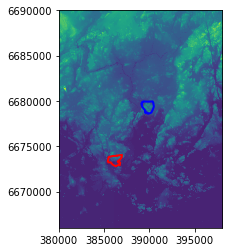

In [3]:
# Plot the Polygons on top of the DEM
ax = kallio.plot(facecolor='None', edgecolor='red', linewidth=2)
ax = pihlajamaki.plot(ax=ax, facecolor='None', edgecolor='blue', linewidth=2)

# Plot DEM
show((dem, 1), ax=ax)

**Which one is higher? Kallio or Pihlajamäki? We can use zonal statistics to find out!**

- First we need to get the values of the dem as numpy array and the affine of the raster

In [6]:
# Read the raster values
array = dem.read(1)

# Get the affine
affine = dem.transform

- Now we can calculate the zonal statistics by using the function `zonal_stats`.

In [9]:
# Calculate zonal statistics for Kallio
zs_kallio = zonal_stats(kallio, array, affine=affine, stats=['min', 'max', 'mean', 'median', 'majority'])

# Calculate zonal statistics for Pihlajamäki
zs_pihla = zonal_stats(pihlajamaki, array, affine=affine, stats=['min', 'max', 'mean', 'median', 'majority'])


C:\ProgramData\Anaconda3\lib\site-packages\rasterstats\io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Okey. So what do we have now?

In [10]:
print(zs_kallio)
print(zs_pihla)

[{'min': -2.1760001182556152, 'max': 37.388999938964844, 'mean': 12.759059456081534, 'median': 11.267999649047852, 'majority': 0.3490000069141388}]
[{'min': 8.73799991607666, 'max': 46.30400085449219, 'mean': 24.560033970865877, 'median': 24.17300033569336, 'majority': 10.41100025177002}]


Super! Now we can see that Pihlajamäki seems to be slightly higher compared to Kallio.

# Read Cloud Optimized Geotiffs

The following materials are based on [this tutorial](https://geohackweek.github.io/raster/04-workingwithrasters/). Read more from that tutorial until this one get's better updated.

- Let's read a Landsat TIF profile from AWS cloud storage:

In [9]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Specify the path for Landsat TIF on AWS
fp = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

# See the profile
with rasterio.open(fp) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


- Let's plot a low resolution overview:

Decimation factor= 81
array type:  <class 'numpy.ndarray'>
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


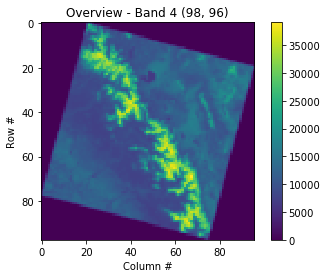

In [7]:
%matplotlib inline
# Open the COG
with rasterio.open(fp) as src:
    # List of overviews from biggest to smallest
    oviews = src.overviews(1) 
    
    # Retrieve the smallest thumbnail
    oview = oviews[-1] 
    print('Decimation factor= {}'.format(oview))
    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

- Let's fix the NoData values to be `NaN` instead of 0:

Decimation factor= 81


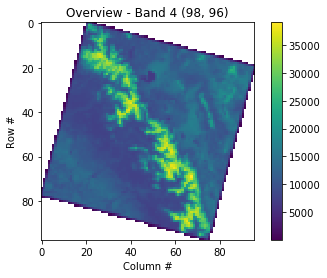

In [10]:
# Open the file
with rasterio.open(fp) as src:
    # Access the overviews
    oviews = src.overviews(1)
    oview = oviews[-1]
    
    print('Decimation factor= {}'.format(oview))
    
    # Read the thumbnail
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
    # Convert the values into float
    thumbnail = thumbnail.astype('f4')
    
    # Convert 0 values to NaNs
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

- Let's take a subset from high resolution image:

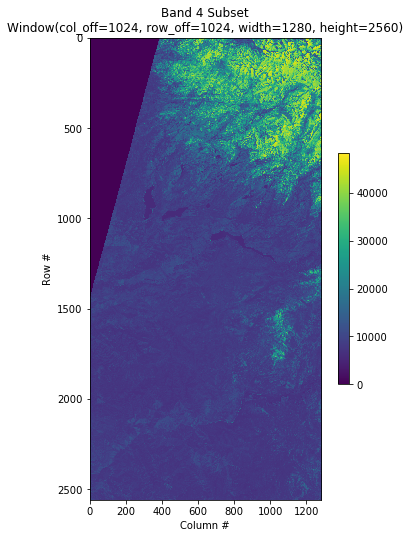

In [11]:
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

with rasterio.open(fp) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

These commands demonstrate the basics how to use COGs to retrieve data from the cloud.